# Step 1: data balancing by augmentation
In this section we will perform data augmentation to compensate those whale categories that have very few training samples.

In [1]:
import math
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import sys
import shutil
import random
import imageio

from six.moves import cPickle as pickle

from tqdm import tqdm

%matplotlib inline

## Extracting dataset

In [2]:
# Inputs
train_zip_file_name = 'train.zip'
extract_dir_name = 'train_unbalanced'
labels_file_name = 'train.csv'

path_to_zip_file = os.path.join(os.path.abspath('../data'), train_zip_file_name)
directory_to_extract = os.path.join(os.path.abspath('../data'), extract_dir_name)
train_unbalanced_path = os.path.join(directory_to_extract,'train')
labels_file_path = os.path.join(os.path.abspath('../data'),labels_file_name)

# Only extract if directory dosn't exist

if not os.path.exists(directory_to_extract):
    zip_ref = zp.ZipFile(path_to_zip_file, 'r')
    zip_ref.extractall(directory_to_extract)
    zip_ref.close()

### Data augmentation settup

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=False,
        fill_mode='nearest')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Definition of useful functions to copy images and augment data

In [4]:
def copy_files_to_dir(nfiles, source_dir, destination_dir, maximum=0):
    """
    Description: copy a given set of files from a source directory to a destination
    directory, optionally you can also set a maximum number of images to be copied
    -> nfiles: list of files names
    -> source_dir: path of the directory where the files will be copied from
    -> destination_dir: path of the directory where the files will be copied
    -> maximum: maximum number of files to be copied
    """
    for index, nfile in enumerate(nfiles):
            full_file_path = os.path.join(source_dir, nfile)
            if (os.path.isfile(full_file_path)):
                shutil.copy(full_file_path, destination_dir)
            if (maximum != 0) and index >= maximum-1:
                return
            
def copy_images_to_dir_expand(images, source_dir, destination_dir, maximum=0, minimum=0):
    """
    Description: copy a given set of images from a source directory to a destination
    directory, optionally you can also set a maximum number of images to be copied and
    a minimum images to be copied. In case that the provided list of images is shorter than
    the speficied minimum the images will be augmented.
    -> images: list of files images
    -> source_dir: path of the directory where the files will be copied from
    -> destination_dir: path of the directory where the files will be copied
    -> maximum: maximum number of files to be copied
    -> minimum: minimum number of files to be copied
    """
    copy_files_to_dir(images, source_dir, destination_dir, maximum)
    if minimum != 0 and len(images) < minimum:
        for index in range(1,minimum - len(images)):
            image_ex = load_img(os.path.join(source_dir, random.choice(images)))
            x = img_to_array(image_ex)
            x = x.reshape((1,) + x.shape) 
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=destination_dir, save_prefix='exp_', save_format='jpeg'):
                break  # otherwise the generator would loop indefinitely
                    
def generate_file_structure(root_path, ids_map, source_dir=None, maximum=0, minimum=0):
    """
    Description: given a root path it generates a tree folder structure for all
    the image ids provieded as input
    -> root_path: list of files names
    -> source_dir: path of the directory where the files will be copied from
    include this path if you want to fill the generated tree with images (optional)
    -> maximum: maximum number of files to be copied (optional)
    -> minimum: minimum number of files to be copied (optional)
    """
    progress = 0
    print('Progress '+str(progress)+' %')
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    # Creating a folder for each whale id
    #New folder names set
    folder_ids = set(ids_map['Id'].values.tolist())
    for index, folder_id in enumerate(folder_ids):
        new_path_folder = os.path.join(root_path, folder_id)
        if not os.path.exists(new_path_folder):
            os.makedirs(new_path_folder)
        if source_dir is not None:
            images = ids_map[ids_map['Id'] == folder_id]['Image'].values.tolist()
            copy_images_to_dir_expand(images, source_dir, new_path_folder, maximum, minimum)
        if(round(100*float(index)/float(len(folder_ids))) > progress):
            print('Progress '+str(round(100*float(index)/float(len(folder_ids))))+' %')
        progress = round(100*float(index)/float(len(folder_ids)))

## Conversion from RBG to Greyscale and Resize Parameters
The following function will take an image and, if it is in RGB, will aplly a conversion from RGB to greyscale

In [5]:
#Weights RGB used for image convesion to greyscale
R_WEIGHT = 0.299
G_WEIGHT = 0.587
B_WEIGHT = 0.114
#Target size in pixels for reshape
DATASET_HEIGHT = 44
DATASET_WIDTH = 82

In [6]:
#input is a file path that should point to an image file.
#output is the Greyscale version of that image.
def convert_image_to_greyscale(image_path, verbose = False):
    #Read image from given filepath and also print its shape for information
    image = imageio.imread(image_path)
    if verbose:
        print("Image shape = {}".format(image.shape))
    
    # init 2D numpy array thay will contained the greyscale image to return
    grey = np.zeros((image.shape[0], image.shape[1])) 
    
    #detect if provided image is already in greysaale (Assumption is that there is only one 
    #layer, so shape[2] not existent). If so, return the input as output.
    if len(image.shape) < 3 :
        if verbose:
            print("Image {} is already in Greyscale.".format(image_path) )
        return image
    #If image shape[2] is 3 (asume RGB) we will convert it to gresycale. If shape[2] exists but reports 1
    # then we detect it and return the input image as an output.
    # if shape[2] its not 3 nor 1 we will raise an exception due to invalid value
    try:
        assert( image.shape[2] == 3 )
        assert( 1.01 > (R_WEIGHT + G_WEIGHT + B_WEIGHT) > 0.99 ) #Ensure weights are valid, they add up to 1.0
        grey = R_WEIGHT * image[:,:, 0] + G_WEIGHT * image[:,:, 1] + B_WEIGHT * image[:,:, 2]
    except AssertionError:
        if image.shape[2] == 1:
            if verbose:
                print("Image {} is already in Greyscale.".format(image_path) )
            grey = image
        else:
            raise ValueError("Image {} is not in RGB format nor in Greyscale. It has {} layers. Please \
              double check.".format(image_path, image.shape[2]))
    return grey

#### Resize image to desried size
The following function will take a np vector representing a greyscale image and resize it to a desired size.

For Resample:
- Image.NEAREST (use nearest neighbour)
- Image.BILINEAR (linear interpolation) 
- Image.BICUBIC (cubic spline interpolation)
- Image.LANCZOS (a high-quality downsampling filter)
If omitted, or if the image has mode “1” or “P”, it is set PIL.Image.NEAREST.

In [7]:
#input a greyscale np representing an image
#output a greyscale np representing theinput image rechaped to different dimensions
def resize_image(image_np):
    _img = Image.fromarray(image_np) 
    _img = _img.resize( (DATASET_WIDTH , DATASET_HEIGHT) , Image.BILINEAR )
    assert(_img.size[0] == DATASET_WIDTH)
    assert(_img.size[1] == DATASET_HEIGHT)
    return np.array(_img.getdata(), np.uint8).reshape(_img.size[1], _img.size[0])
    

## Pickle images

In [8]:
#Input: np to pickle
#Actions: save input in a .pickle file in desired folder
#Output successful
def maybe_pickle(dest_dir, dataset, file_name, force=False):
    _success = True
    _msg = "No action"
    _set_filename = file_name + '.pickle'
    _file_path = os.path.join(dest_dir, _set_filename)
    if os.path.exists(_file_path) and not force:
        # You may override by setting force=True.
        _msg = '{} already present - Skipping pickling.'.format(_set_filename)
    else:
        try:
            with open(_file_path, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                _msg = "Success"
                f.close()
        except Exception as e:
            _msg = 'Unable to save data to {} : {}'.format(_set_filename, e)
            _success = False
    return _success, _msg
        
#Input: Root path where all subfolders are stored
#Actions: Reshape images and do pickle in every subfolder
def resize_and_pickle_images_in_dir(root_path, verbose = False):  
    _progress = 0
    _prev_progress = 0
    print("Progress {}%: ".format(_progress))
    #Make sure the path exist before executing the next steps.
    if not os.path.exists(root_path):
        raise ValueError("Path {} idoes not exist.".format(root_path) )
     
    # get all files' and folders' names in the current directory
    _filenames= os.listdir(root_path) 
    _sub_folders = []
    # loop through all the files and folders and check whether the current object is a folder or not
    for filename in _filenames: 
        _path = os.path.join(os.path.abspath(root_path), filename)
        # if it is a directory add it to subdirectories list
        if os.path.isdir(_path): 
            _sub_folders.append(_path)
    
    #Obtain number of subfolders for further checking and progress monitoring
    _total_folders = len(_sub_folders)
    
    #Loop through all subfolders
    for ix ,folder in enumerate(_sub_folders):
        _image_list = [f for f in os.listdir(folder) if (f.endswith('.jpg') or f.endswith('.jpeg'))]
        if verbose:
            print("In folder {} found {} images.".format( folder , len(_image_list)) )
            
        #Create empty np (intended) to store all processed image of a specific folder
        _image_concentrator = np.ndarray(shape = ( len(_image_list) , DATASET_HEIGHT, DATASET_WIDTH))
        #Loop through all images in a subfolder and reshape them. Save the reshaped in a np placeholder that will be saved in a pickle file
        for num, image_file in enumerate(_image_list):
            _image_path = os.path.join(os.path.abspath(folder), image_file)
            _image_concentrator[num , : , :] = resize_image( convert_image_to_greyscale(_image_path, verbose) ) 
            
        #Perform some checks before apply pickle
        assert(len(_image_list) == _image_concentrator.shape[0])
        
        #Output information
        if verbose:
            print("Reshaped and stored the {} images from folder {}".format( \
                                                    _image_concentrator.shape[2] , folder) )
        #Let's save the np as a .pickle:
        _success, _msg = maybe_pickle(folder, _image_concentrator,  os.path.basename(folder), force=False)
        if verbose:
            print("Pickle folder {} with message: ".format( folder) + _msg)
        #Now we make sure the operation was successful:
        if not _success:
            print("ERROR occurred in maybe_pickle: " + _msg)
        
        #Monitor Progress
        _progress = ((100 * ix /_total_folders)  )
        if ( _progress% 2 == 0) and (_progress > _prev_progress):
            _prev_progress = _progress
            print("Progress {}%".format( 100 * ix /_total_folders))
     
    ###REMEMBER TO NORMALIZE BEFORE PICKLE
    print("Progress 100%")    
    return

## Generate train balance file structure

In [9]:
#Balance dataset
min_n_per_class = 5
max_n_per_class = 200
train_balanced_dir_name = 'train_balanced'
ids_map = pd.read_csv(labels_file_path)
path_train_balanced = os.path.join(os.path.abspath('../data'), train_balanced_dir_name)
generate_file_structure(path_train_balanced, ids_map, train_unbalanced_path, max_n_per_class, min_n_per_class)

Progress 0 %
Progress 1.0 %
Progress 2.0 %
Progress 3.0 %
Progress 4.0 %
Progress 5.0 %
Progress 6.0 %
Progress 7.0 %
Progress 8.0 %
Progress 9.0 %
Progress 10.0 %
Progress 11.0 %
Progress 12.0 %
Progress 13.0 %
Progress 14.0 %
Progress 15.0 %
Progress 16.0 %
Progress 17.0 %
Progress 18.0 %
Progress 19.0 %
Progress 20.0 %
Progress 21.0 %
Progress 22.0 %
Progress 23.0 %
Progress 24.0 %
Progress 25.0 %
Progress 26.0 %
Progress 27.0 %
Progress 28.0 %
Progress 29.0 %
Progress 30.0 %
Progress 31.0 %
Progress 32.0 %
Progress 33.0 %
Progress 34.0 %
Progress 35.0 %
Progress 36.0 %
Progress 37.0 %
Progress 38.0 %
Progress 39.0 %
Progress 40.0 %
Progress 41.0 %
Progress 42.0 %
Progress 43.0 %
Progress 44.0 %
Progress 45.0 %
Progress 46.0 %
Progress 47.0 %
Progress 48.0 %
Progress 49.0 %
Progress 50.0 %
Progress 51.0 %
Progress 52.0 %
Progress 53.0 %
Progress 54.0 %
Progress 55.0 %
Progress 56.0 %
Progress 57.0 %
Progress 58.0 %
Progress 59.0 %
Progress 60.0 %
Progress 61.0 %
Progress 62.0 %
Prog

## Whale_id.pckle creation
Lets iterate through all folders to transform images and save pickle for later use

In [10]:
resize_and_pickle_images_in_dir(path_train_balanced)

Progress 0%: 
Progress 2%
Progress 4%
Progress 6%
Progress 8%
Progress 10%
Progress 12%
Progress 14%
Progress 16%
Progress 18%
Progress 20%
Progress 22%
Progress 24%
Progress 26%
Progress 28%
Progress 30%
Progress 32%
Progress 34%
Progress 36%
Progress 38%
Progress 40%
Progress 42%
Progress 44%
Progress 46%
Progress 48%
Progress 50%
Progress 52%
Progress 54%
Progress 56%
Progress 58%
Progress 60%
Progress 62%
Progress 64%
Progress 66%
Progress 68%
Progress 70%
Progress 72%
Progress 74%
Progress 76%
Progress 78%
Progress 80%
Progress 82%
Progress 84%
Progress 86%
Progress 88%
Progress 90%
Progress 92%
Progress 94%
Progress 96%
Progress 98%
Progress 100%


## Test resize_image and convert_image_to_greyscale
Let's test the functions resize_image and convert_image_to_greyscale

Converting image /notebooks/humpbackwhale/data/train_balanced/w_deb33de/2029e9b6.jpg :


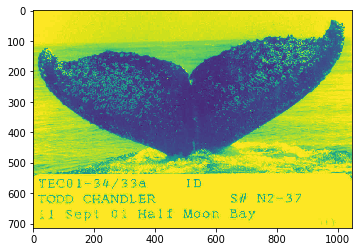

Image shape = (714, 1046)
Image /notebooks/humpbackwhale/data/train_balanced/w_deb33de/2029e9b6.jpg is already in Greyscale.


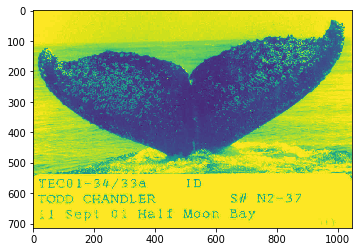

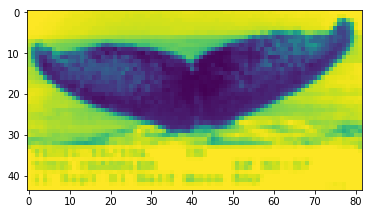

(44, 82)


In [11]:
path = os.path.join(path_train_balanced,'w_deb33de')
im_file = os.path.join(path, random.choice(os.listdir(path)))
print("Converting image {} :".format(im_file))

image = imageio.imread(im_file)
plt.imshow(image) #load
plt.show() 

image_grey = convert_image_to_greyscale(im_file, True)
_image_grey = Image.fromarray(image_grey)
_image_grey.show()
plt.imshow(image_grey) #load
plt.show() 

image_final = resize_image(image_grey)
_image_final = Image.fromarray(image_final)
_image_final.show()
plt.imshow(image_final) #load
plt.show() 
print(image_final.shape)